In [1]:
import sys
import os
import time
import logging
import datetime
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


# import local files if necessary
sys.path.append('..//src')
import training_data as td
importlib.reload(td)

# load dotenv
load_dotenv()

# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.DEBUG)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')


def load_config(file_path='config.yaml'):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
config = load_config()


#### Load the datasets

In [8]:
importlib.reload(td)
config = load_config()


# retrieve prices data
if 'prices_filled_df' not in locals():
    prices_df = td.retrieve_prices_data()

    # fill gaps in prices data
    prices_filled_df,prices_outcomes_df = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])
logger.info(f"Prices data shape: {prices_df.shape}")


# Retrieve or load transfers data
if 'transfers_df' not in locals():
    transfers_df = td.retrieve_transfers_data(config['modeling']['modeling_period_start'])
logger.info(f"Transfers data shape: {transfers_df.shape}")


# Calculate and clean profits data
profits_df = td.calculate_wallet_profitability(transfers_df, prices_filled_df)
profits_df, exclusions_profits_df = td.clean_profits_df(profits_df, config['data_cleaning']['profitability_filter'])
logger.info(f"Profits data shape: {profits_df.shape}")


[08/Sep/2024 13:42:16] INFO [dreams_core.core.<module>:14] Prices data shape: (120763, 3)
[08/Sep/2024 13:42:16] INFO [dreams_core.core.<module>:19] Transfers data shape: (12822335, 5)
[08/Sep/2024 13:42:16] INFO [dreams_core.core.calculate_wallet_profitability:340] Starting generation of profits_df...
[08/Sep/2024 13:42:19] DEBUG [dreams_core.core.calculate_wallet_profitability:352] <Step 1> (Merge transfers and prices): 2.41 seconds
[08/Sep/2024 13:42:21] DEBUG [dreams_core.core.calculate_wallet_profitability:364] <Step 2> (Remove records before first price date): 2.60 seconds
[08/Sep/2024 13:42:28] DEBUG [dreams_core.core.calculate_wallet_profitability:377] <Step 3> Offset prices and balances for profitability logic: 6.20 seconds
[08/Sep/2024 13:42:31] DEBUG [dreams_core.core.calculate_wallet_profitability:382] <Step 3> Calculate profitability: 9.22 seconds
[08/Sep/2024 13:42:34] DEBUG [dreams_core.core.calculate_wallet_profitability:390] <Step 3> Calculate rate of return 12.24 seco

### Work with the datasets

In [11]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
0,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2024-02-29,0,1e-08,9.22761625474,0,0,9.22761625474e-08,0,0,0,NaN
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000035b5e5ad9019092c665357240f594e,2024-02-29,0,1.3e-07,9.22761625474,0,0,1.19959011312e-06,0,0,0,NaN
2,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000003b3cc22af3ae1eac0440bcee416b40,2023-08-30,-0.00227477,0.0101113,0.235876493831,0,0,0.00238501799208,-0.000536564771873,0,0,NaN
3,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000003b3cc22af3ae1eac0440bcee416b40,2023-09-07,0.00328122,0.01339252,0.210109734917,-0.000260535429412,-0.000260535429412,0.00281389882707,0.000689416264404,0.000689416264404,0.000689416264404,-0.37790728601
4,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000003b3cc22af3ae1eac0440bcee416b40,2023-11-27,-0.01092158,0.00247094,1.56542850451,0.0181511337281,0.0178905982987,0.00386807990893,-0.0170969526463,0,0.000689416264404,25.950357168


In [12]:
importlib.reload(td)
config = load_config()

sharks_df = td.classify_sharks(profits_df, config['modeling'])
sharks_df.head()

[08/Sep/2024 13:59:13] INFO [dreams_core.core.classify_sharks:467] identifying shark wallets...


KeyError: 'profits_total'

NameError: name 'sharks_df' is not defined

In [5]:
importlib.reload(td)
config = load_config()



# # Classify sharks
# sharks_df = td.classify_sharks(profits_cleaned_df, config['modeling'])

[08/Sep/2024 13:26:16] INFO [dreams_core.core.calculate_wallet_profitability:340] Starting generation of profits_df...
[08/Sep/2024 13:26:18] DEBUG [dreams_core.core.calculate_wallet_profitability:352] <Step 1> (Merge transfers and prices): 2.31 seconds
[08/Sep/2024 13:26:20] DEBUG [dreams_core.core.calculate_wallet_profitability:364] <Step 2> (Remove records before first price date): 1.95 seconds
[08/Sep/2024 13:26:26] DEBUG [dreams_core.core.calculate_wallet_profitability:377] <Step 3> Offset prices and balances for profitability logic: 6.00 seconds
[08/Sep/2024 13:26:29] DEBUG [dreams_core.core.calculate_wallet_profitability:382] <Step 3> Calculate profitability: 8.84 seconds
[08/Sep/2024 13:26:32] DEBUG [dreams_core.core.calculate_wallet_profitability:390] <Step 3> Calculate rate of return 11.82 seconds
[08/Sep/2024 13:26:32] INFO [dreams_core.core.calculate_wallet_profitability:396] Generated profits df after 16.33 seconds
[08/Sep/2024 13:26:32] INFO [dreams_core.core.clean_profit

[08/Sep/2024 13:27:02] INFO [dreams_core.core.clean_profits_df:414] Starting generation of profits_cleaned_df...
[08/Sep/2024 13:27:06] INFO [dreams_core.core.clean_profits_df:433] Finished cleaning profits_df after 3.49 seconds. Removed 265 coin-wallet pairs that breached profit or loss threshold of $10.0M


In [46]:
a = 'wallet2'
c = 'ETH'
result[(result['wallet_address'] == a) & (result['coin_id'] == c)]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_cumulative_inflows,total_return
3,ETH,wallet2,2023-01-01,50,50,1500,0,0,75000,75000,75000,75000,0
5,ETH,wallet2,2023-02-01,25,75,1600,5000,5000,120000,40000,40000,115000,0.0434782608696
12,ETH,wallet2,2023-04-01,-10,65,1800,15000,20000,117000,-18000,0,115000,0.173913043478


In [32]:
importlib.reload(td)
result = td.calculate_wallet_profitability(sample_transfers_df(), sample_prices_df())
result.sort_values(['coin_id','wallet_address','date'])

[08/Sep/2024 12:36:45] INFO [dreams_core.core.calculate_wallet_profitability:340] Starting generation of profits_df...
[08/Sep/2024 12:36:45] DEBUG [dreams_core.core.calculate_wallet_profitability:352] <Step 1> (Merge transfers and prices): 0.01 seconds
[08/Sep/2024 12:36:45] DEBUG [dreams_core.core.calculate_wallet_profitability:364] <Step 2> (Remove records before first price date): 0.00 seconds
[08/Sep/2024 12:36:45] DEBUG [dreams_core.core.calculate_wallet_profitability:377] <Step 3> Offset prices and balances for profitability logic: 0.00 seconds
[08/Sep/2024 12:36:45] DEBUG [dreams_core.core.calculate_wallet_profitability:382] <Step 3> Calculate profitability: 0.00 seconds
[08/Sep/2024 12:36:45] DEBUG [dreams_core.core.calculate_wallet_profitability:390] <Step 3> Calculate rate of return 0.00 seconds
[08/Sep/2024 12:36:45] INFO [dreams_core.core.calculate_wallet_profitability:396] Generated profits df after 0.02 seconds


,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_cumulative_inflows,total_return
0,BTC,wallet1,2023-01-01,10,10,20000,0,0,200000,200000,200000,200000,0
1,BTC,wallet1,2023-02-01,5,15,21000,10000,10000,315000,105000,105000,305000,0.0327868852459
4,BTC,wallet2,2023-01-01,20,20,20000,0,0,400000,400000,400000,400000,0
2,ETH,wallet1,2023-01-01,100,100,1500,0,0,150000,150000,150000,150000,0
3,ETH,wallet2,2023-01-01,50,50,1500,0,0,75000,75000,75000,75000,0
5,ETH,wallet2,2023-02-01,25,75,1600,5000,5000,120000,40000,40000,115000,0.0434782608696
6,MYRO,wallet3,2023-01-01,1000,1000,10,0,0,10000,10000,10000,10000,0
7,MYRO,wallet3,2023-02-01,500,1500,15,5000,5000,22500,7500,7500,17500,0.285714285714
8,MYRO,wallet3,2023-03-01,-750,750,12,-4500,500,9000,-9000,0,17500,0.0285714285714


In [33]:
result[(result['wallet_address'] == 'wallet3') & (result['coin_id'] == 'MYRO')]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_cumulative_inflows,total_return
6,MYRO,wallet3,2023-01-01,1000,1000,10,0,0,10000,10000,10000,10000,0
7,MYRO,wallet3,2023-02-01,500,1500,15,5000,5000,22500,7500,7500,17500,0.285714285714
8,MYRO,wallet3,2023-03-01,-750,750,12,-4500,500,9000,-9000,0,17500,0.0285714285714


In [9]:
coin_id = '0b9d343d-4e25-4d22-b49c-fa17509a0333'
wallet_address = '0x000000000005af2ddc1a93a03e9b7014064d3b8d'
profits_df[(profits_df['coin_id']==coin_id) & (profits_df['wallet_address']==wallet_address)]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_inflows,usd_cumulative_inflows,usd_balance,rate_of_return
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2024-02-29,0,1e-08,9.22761625474,0,0,0,0,9.22761625474e-08,NaN


In [13]:
df = transfers_df[transfers_df['coin_id']==coin_id]
df = df[df['wallet_address']==wallet_address]
df

,coin_id,wallet_address,date,net_transfers,balance
0,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2023-01-30,1e-08,1e-08
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2024-02-29,0,1e-08


In [ ]:
modeling_period_start = pd.to_datetime(modeling_period_start)
training_period_end = modeling_period_start - pd.Timedelta(days=1)

all_pairs = transfers_df[['coin_id', 'wallet_address']].drop_duplicates()

In [33]:
# Filter out data on or after the modeling period start date
modeling_period_start = pd.to_datetime(modeling_period_start)
filtered_profits_df = profits_df[profits_df['date'] < modeling_period_start].copy()

# Calculate USD balance
filtered_profits_df['usd_balance'] = filtered_profits_df['balance'] * filtered_profits_df['price']

# Filter out wallets that have never reached the balance_threshold for a coin_id
eligible_wallets_df = filtered_profits_df.groupby(['coin_id', 'wallet_address'])['usd_balance'].max().reset_index()
eligible_wallets_df = eligible_wallets_df[eligible_wallets_df['usd_balance'] >= balance_threshold]

# Get the last profitability for each wallet-coin pair before the modeling period start
last_profitability = filtered_profits_df.sort_values('date').groupby(['coin_id', 'wallet_address']).last()['profits_total'].reset_index()

# Classify wallets as sharks based on lifetime profitability and eligibility
sharks_df = eligible_wallets_df.merge(last_profitability, on=['coin_id', 'wallet_address'])
sharks_df['is_shark'] = sharks_df['profits_total'] >= profitability_threshold


,coin_id,sharks
0,06b54bc2-8688-43e7-a49a-755300a4f995,361
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,130
2,0db96a94-082b-4e13-a315-860850e9ff4f,39
3,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,7
4,0eedc336-a78e-4b25-957e-57117227ef78,61
...,...,...
117,f066f324-3447-42dd-8144-c86110185a24,0
118,f64ac466-300d-43d4-8c36-ef26a7a48977,0
119,f68b64ae-61d5-4dd6-b448-4ae9c754bd07,140
120,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,71


In [40]:
# count of all wallets for each coin
summary_df = sharks_df.groupby('coin_id').size().reset_index(name='all_wallets')

# count of shark wallets for each coin
sharks_count_df = sharks_df.groupby('coin_id')['is_shark'].sum().reset_index(name='shark_wallets')

# merge and calculate shark rate
summary_df = pd.merge(summary_df, sharks_count_df, on='coin_id', how='left')
summary_df['shark_rate'] = summary_df['shark_wallets']/summary_df['all_wallets']

summary_df



,coin_id,all_wallets,shark_wallets,shark_rate
0,06b54bc2-8688-43e7-a49a-755300a4f995,7532,361,0.0479288369623
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,1323,130,0.098261526833
2,0db96a94-082b-4e13-a315-860850e9ff4f,475,39,0.0821052631579
3,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,180,7,0.0388888888889
4,0eedc336-a78e-4b25-957e-57117227ef78,2842,61,0.021463757917
...,...,...,...,...
117,f066f324-3447-42dd-8144-c86110185a24,8,0,0
118,f64ac466-300d-43d4-8c36-ef26a7a48977,11,0,0
119,f68b64ae-61d5-4dd6-b448-4ae9c754bd07,1470,140,0.0952380952381
120,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,398,71,0.178391959799


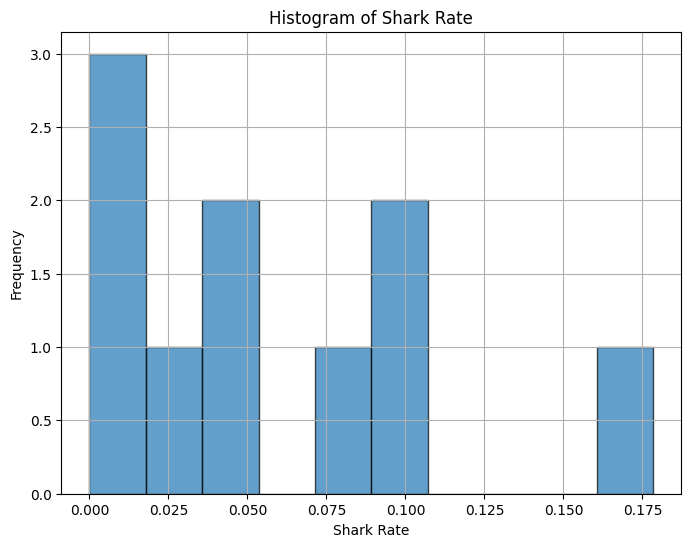

In [41]:
import matplotlib.pyplot as plt

# Example shark_rate data
shark_rate_data = [
    0.0479288369623, 0.098261526833, 0.0821052631579, 0.0388888888889, 0.021463757917,
    0, 0, 0.0952380952381, 0.178391959799, 0
]

# Create histogram of shark_rate
plt.figure(figsize=(8, 6))
plt.hist(shark_rate_data, bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Shark Rate')
plt.xlabel('Shark Rate')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plot
plt.show()


In [12]:
# profits_df['profits_total'].sum()
profits_df_old['profits_total'].count()

3205467468437.944

In [14]:
profits_df['profits_total'].sum()

3205467468437.944

In [16]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,first_transfer_date,adjusted_net_transfers,profitability_change,profitability_cumulative
0,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-06-29,52.6727892183,52.6727892183,0.0824039688436,2024-06-29,52.6727892183,0,0
1,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-07-15,17.8010851795,70.4738743978,0.12681569103,2024-06-29,17.8010851795,2.33928928152,2.33928928152
2,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-08-31,30.3633665636,100.837240961,0.122419792313,2024-06-29,30.3633665636,-0.309796014047,2.02949326748
3,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-15,-3.63797880709e-12,-3.63797880709e-12,0.12681569103,2024-07-15,-3.63797880709e-12,0,0
4,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-25,0.132674074648,0.132674074644,0.190726300024,2024-07-15,0.132674074648,-2.3250544107e-13,-2.3250544107e-13


count   17177272.00
mean         208.11
std        80014.31
min     -9946827.35
25%          -52.35
50%            0.73
75%          176.77
max      9943893.50
Name: profitability, dtype: float64


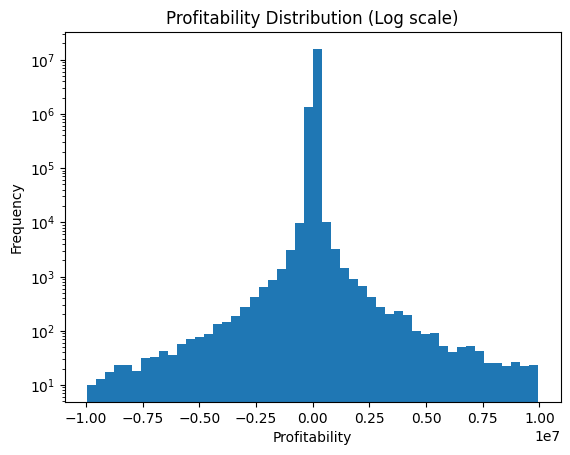

In [9]:

# Check the distribution of profitability values again
# print(profits_df['profitability'].describe())
print(profits_cleaned_df['profitability'].describe())

import matplotlib.pyplot as plt

# Plot distribution of profitability values
profits_cleaned_df['profitability'].plot(kind='hist', bins=50, logy=True)
plt.title('Profitability Distribution (Log scale)')
plt.xlabel('Profitability')
plt.show()

